# Initial Installs & Imports

In [1]:
!pip install tensorflow
!pip install keras==3.5.0
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


# Downloading the Dataset

## Upload Kaggle API Key File

In [2]:
files.upload() # Upload kaggle.json API key
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


## Download & Unzip Dataset

In [3]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources
!unzip -q tomato-disease-multiple-sources.zip

Dataset URL: https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources
License(s): CC0-1.0
 99% 1.35G/1.37G [00:12<00:00, 123MB/s] 
100% 1.37G/1.37G [00:12<00:00, 116MB/s]


# Formatting the Dataset

## Remove Corrupted Images

In [4]:
from PIL import Image
import os

def verify_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpeg', 'png', 'jpg')):
                try:
                    img = Image.open(os.path.join(root, file))
                    img.verify()
                except (IOError, SyntaxError) as e:
                    print(f'Bad file: {file} removed')
                    os.remove(os.path.join(root, file)) # Removes corrupted image

verify_images('/content/train')
verify_images('/content/valid')


Bad file: HL_(336).png removed


## Create Image Sets for Training, Testing & Validation



In [5]:
import pandas as pd
def create_dataframe(path):
  data=[]
  for folder in os.listdir(path):
    for file in os.listdir(os.path.join(path,folder)):
     data.append([path + folder + '/' + file, folder])
  return pd.DataFrame(data,columns=['filename','label'])

In [6]:
t_df = create_dataframe('/content/train/') # Creates DF for Training/Test (will be split later)
validation_df = create_dataframe('/content/valid/') # Creates DF for Validation

In [7]:
validation_df

,filename,label
0,/content/valid/Septoria_leaf_spot/18d05aef-311...,Septoria_leaf_spot
1,/content/valid/Septoria_leaf_spot/Gls8_lower.jpg,Septoria_leaf_spot
2,/content/valid/Septoria_leaf_spot/069e7256-c9a...,Septoria_leaf_spot
3,/content/valid/Septoria_leaf_spot/63f2b877-978...,Septoria_leaf_spot
4,/content/valid/Septoria_leaf_spot/images (2).jpg,Septoria_leaf_spot
...,...,...
6678,/content/valid/Late_blight/8c7b818d-de11-4989-...,Late_blight
6679,/content/valid/Late_blight/Lb10.JPG,Late_blight
6680,/content/valid/Late_blight/7a711eda-02e6-49fa-...,Late_blight
6681,/content/valid/Late_blight/3dbb0f53-7541-4b25-...,Late_blight


Split t_df (80% to Training / 20% to Testing)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t_df['filename'], t_df['label'], test_size=0.2, random_state=13)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [9]:
train_df

,filename,label
20785,/content/train/healthy/HL_(46).png,healthy
16788,/content/train/Early_blight/f62e84ae-2bd4-4b15...,Early_blight
9342,/content/train/Tomato_mosaic_virus/15f1e22a-9c...,Tomato_mosaic_virus
15308,/content/train/Early_blight/c98f4286-f846-4c26...,Early_blight
12914,/content/train/Bacterial_spot/BS_(332).jpg,Bacterial_spot
...,...,...
866,/content/train/Septoria_leaf_spot/Gls32_change...,Septoria_leaf_spot
24080,/content/train/Late_blight/01ece5a1-8398-4e68-...,Late_blight
74,/content/train/Septoria_leaf_spot/f2c4d017-4a1...,Septoria_leaf_spot
14512,/content/train/Bacterial_spot/662555e4-c996-49...,Bacterial_spot


In [10]:
test_df

,filename,label
19707,/content/train/healthy/h45_change_90.jpg,healthy
6613,/content/train/Spider_mites Two-spotted_spider...,Spider_mites Two-spotted_spider_mite
25447,/content/train/Late_blight/7e5386fc-de1d-4507-...,Late_blight
11821,/content/train/Target_Spot/1cc31c92-0fbd-488a-...,Target_Spot
25441,/content/train/Late_blight/376c3deb-3feb-425b-...,Late_blight
...,...,...
8328,/content/train/powdery_mildew/pm153.jpg,powdery_mildew
3556,/content/train/Leaf_Mold/8bb19b73-9bfc-426e-97...,Leaf_Mold
3095,/content/train/Leaf_Mold/f2da011d-7004-40de-ba...,Leaf_Mold
14113,/content/train/Bacterial_spot/6e5046d4-95c4-46...,Bacterial_spot


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define data generator
datagen = ImageDataGenerator(rescale=1./255)

# Training set
training_set = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Testing Set
testing_set = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Validation Set
validation_set = datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 20680 validated image filenames belonging to 11 classes.
Found 5171 validated image filenames belonging to 11 classes.
Found 6683 validated image filenames belonging to 11 classes.


## Display Class Distributins

In [12]:
label_map = training_set.class_indices
print(label_map)

{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


### Training Distribution

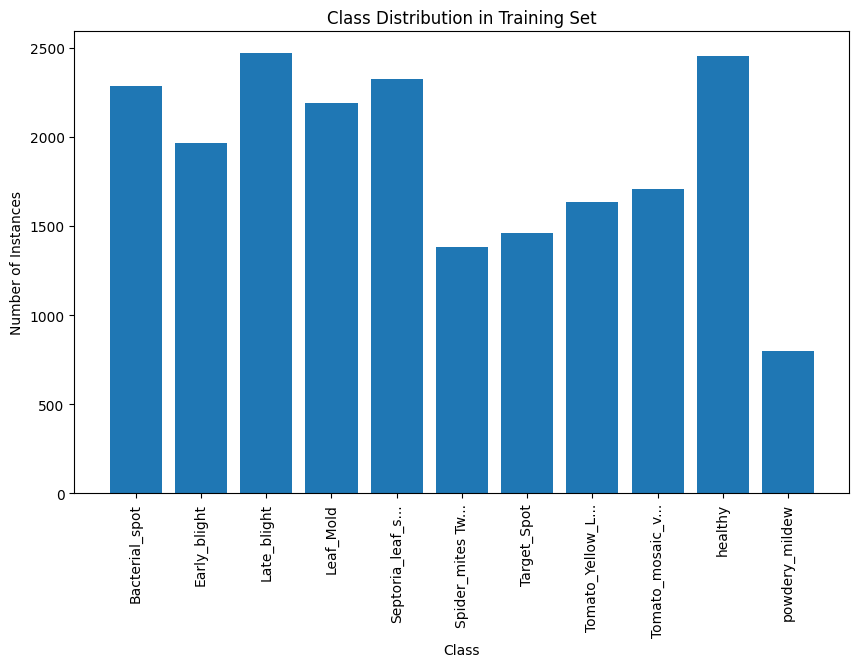

In [13]:
y_true = training_set.classes  # Class labels from the training set

# Calculate the unique class labels and their counts
unique, counts = np.unique(y_true, return_counts=True)

max_label_length = 15

truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, tick_label=truncated_labels)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

### Testing Distribution

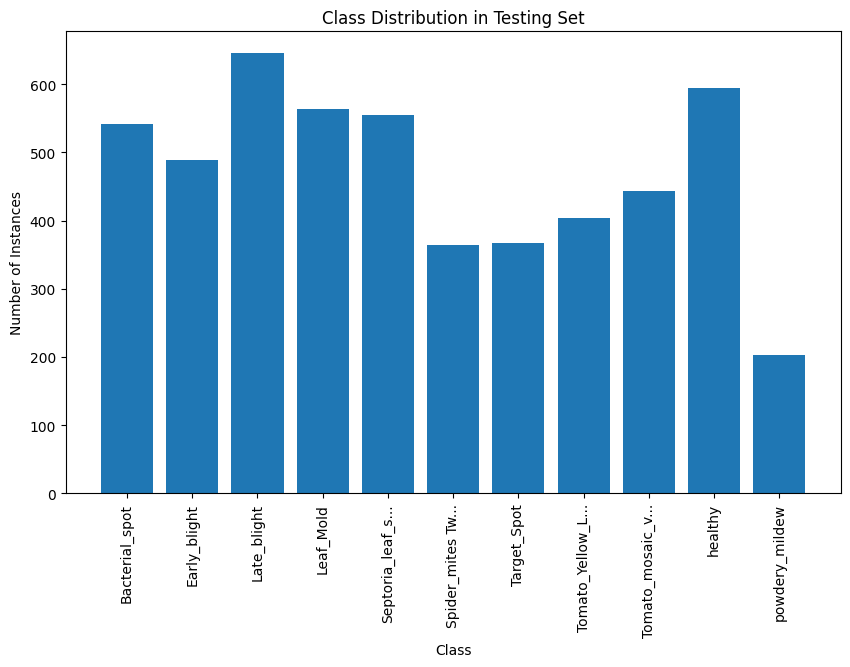

In [14]:
y_true = testing_set.classes  # Class labels from the testing set

# Calculate the unique class labels and their counts
unique, counts = np.unique(y_true, return_counts=True)

max_label_length = 15

# Truncate the labels if they exceed the maximum length
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, tick_label=truncated_labels)
plt.title('Class Distribution in Testing Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

### Validation Distribution

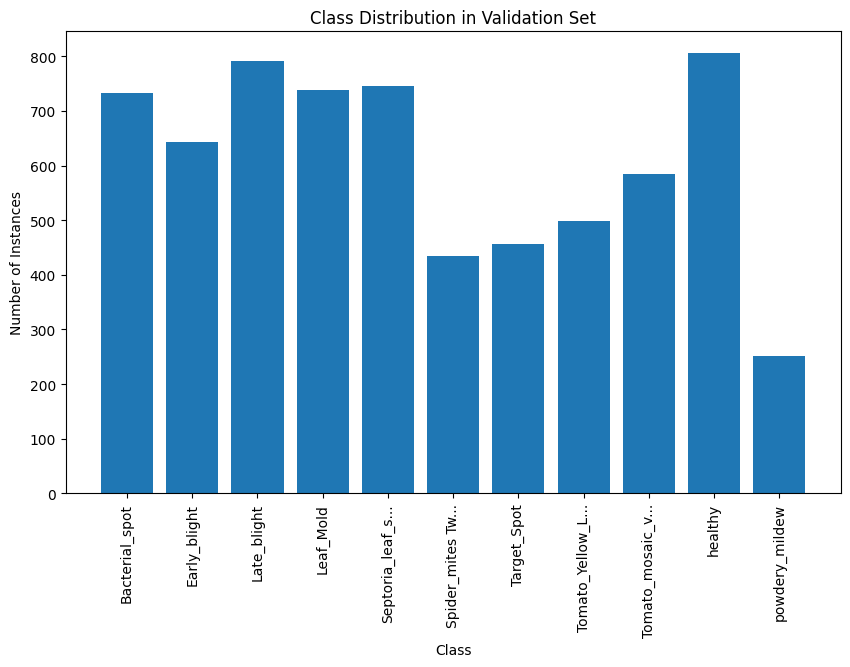

In [15]:
y_true = validation_set.classes  # Class labels from the validation set

# Calculate the unique class labels and their counts
unique, counts = np.unique(y_true, return_counts=True)

max_label_length = 15

# Truncate the labels if they exceed the maximum length
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, tick_label=truncated_labels)
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

### Combined Distribution

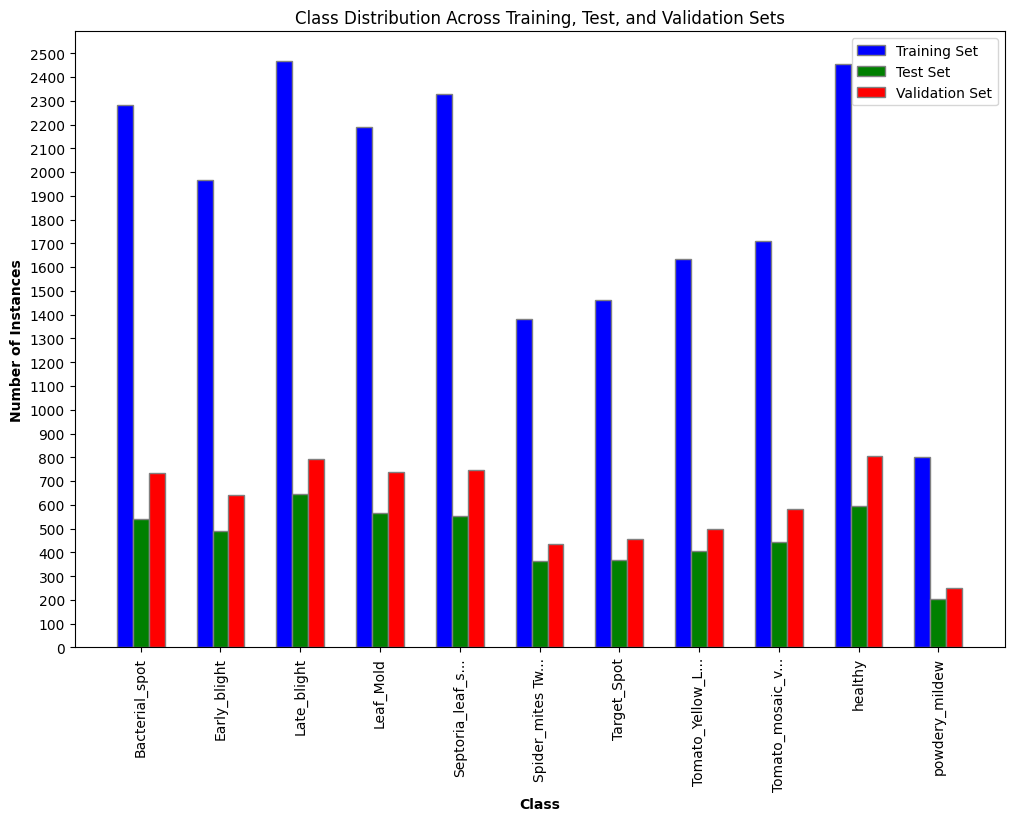

In [16]:
y_train = training_set.classes  # Class labels from the training set generator
y_test = testing_set.classes    # Class labels from the test set generator
y_val = validation_set.classes  # Class labels from the validation set generator

# Label map is the same for all sets
label_map = training_set.class_indices

# Calculate the unique class labels and their counts for each dataset
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)


max_label_length = 15
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Create the bar positions for each dataset
bar_width = 0.2
r1 = np.arange(len(unique_train))  # Positions of bars for the training set
r2 = [x + bar_width for x in r1]   # Positions of bars for the test set
r3 = [x + bar_width for x in r2]   # Positions of bars for the validation set

# Plot the grouped bar chart
plt.figure(figsize=(12, 8))
plt.bar(r1, counts_train, color='blue', width=bar_width, edgecolor='grey', label='Training Set')
plt.bar(r2, counts_test, color='green', width=bar_width, edgecolor='grey', label='Test Set')
plt.bar(r3, counts_val, color='red', width=bar_width, edgecolor='grey', label='Validation Set')

plt.xlabel('Class', fontweight='bold')
plt.ylabel('Number of Instances', fontweight='bold')
plt.title('Class Distribution Across Training, Test, and Validation Sets')

# Add x-ticks on the middle of the group bars
plt.xticks([r + bar_width for r in range(len(unique_train))], truncated_labels, rotation=90)

plt.yticks(np.arange(0, max(max(counts_train), max(counts_test), max(counts_val)) + 100, step=100))

plt.legend()
plt.show()

# Modeling

## Upload Model

In [18]:
import json
import tensorflow

files.upload() # Upload tomato_disease_model.h5
model = tensorflow.keras.models.load_model('tomato_disease_model.h5')

files.upload() # Upload model_history.json
history = json.load(open('model_history.json'))

Saving model_history.json to model_history.json


# Evaluating the Model

## Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Training Loss & Accuracy

In [23]:
evaluation = model.evaluate(training_set)
print(f"Training Loss: {evaluation[0]}")
print(f"Training Accuracy: {evaluation[1]}")

647/647 ━━━━━━━━━━━━━━━━━━━━ 561s 867ms/step - accuracy: 0.9973 - loss: 0.0132
Training Loss: 0.01483970507979393
Training Accuracy: 0.9970502853393555


## Test Loss & Accuracy

In [24]:
evaluation = model.evaluate(testing_set)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 140s 865ms/step - accuracy: 0.9987 - loss: 0.0054
Test Loss: 0.0073586213402450085
Test Accuracy: 0.9980661273002625


## Learning Curve


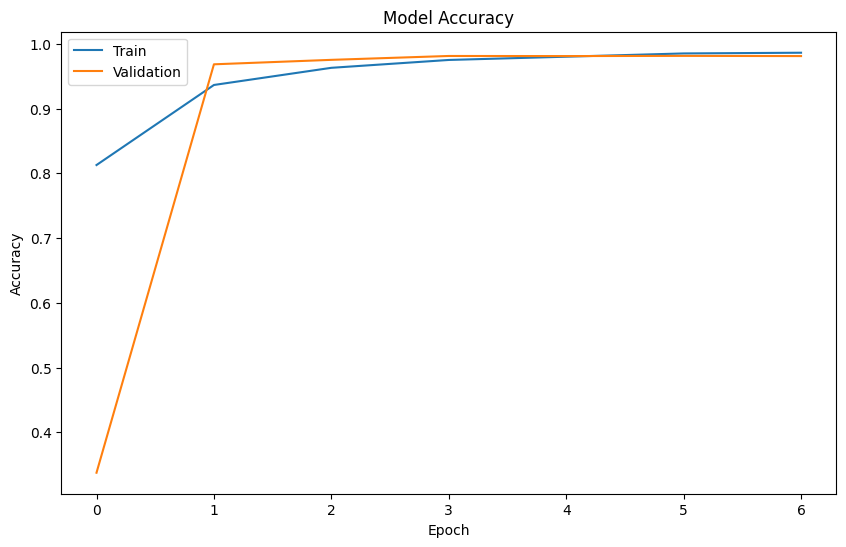

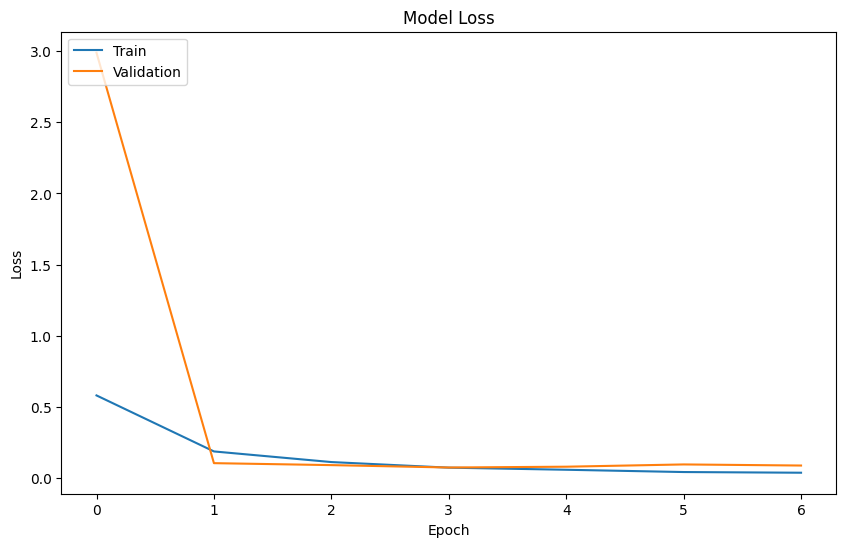

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix

162/162 ━━━━━━━━━━━━━━━━━━━━ 143s 873ms/step


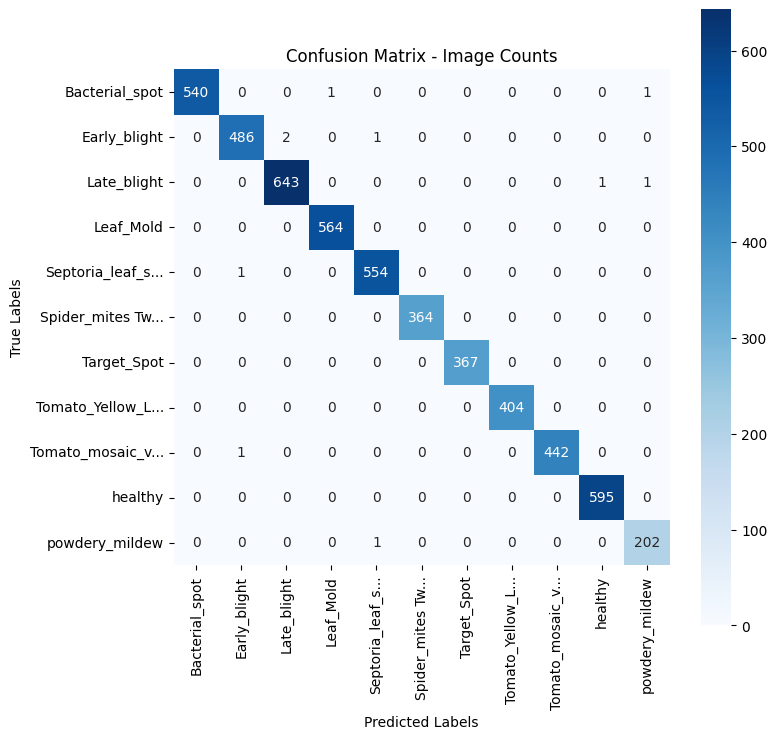

In [25]:
from sklearn.metrics import confusion_matrix

# Predict the classes for the entire test set
testing_set.reset()  # Reset the generator to ensure it goes through all data
label_map = testing_set.class_indices

y_true = testing_set.classes  # Actual class labels
y_pred = model.predict(testing_set)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

max_label_length = 15
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=truncated_labels, yticklabels=truncated_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Image Counts')
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(label_map.keys())))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.98      0.98      0.98       545
                        Early_blight       0.98      0.98      0.98       518
                         Late_blight       0.99      1.00      0.99       633
                           Leaf_Mold       1.00      0.99      0.99       562
                  Septoria_leaf_spot       0.98      0.98      0.98       570
Spider_mites Two-spotted_spider_mite       0.99      0.99      0.99       357
                         Target_Spot       0.99      1.00      0.99       344
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       384
                 Tomato_mosaic_virus       0.99      0.99      0.99       421
                             healthy       1.00      1.00      1.00       636
                      powdery_mildew       0.97      1.00      0.98       201

                            accuracy                          